# Imports

In [21]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.models import PretrainedModel, AlexNetVanilla
from utils.utils import preprocess_images, get_current_time
from utils.config import batch_size, num_epochs, model_str

# Initialize data

In [12]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

# Preprocessing

### Outlier detection and handling

In a normal distribution, 99.7% of the data is within +/- 3 standard deviations of the mean. We can use this to identify outliers in the data. 

Next is deciding on how to handle outliers, e.g.:

- Exclude Outliers: Exclude any voxels that are outliers in any of the images. This is a stringent approach but ensures that your model is not influenced by these extreme values.
- Exclude Outliers on a Per-Image Basis: Instead of excluding a voxel across all images, you could exclude it only for those specific images where it's an outlier. This retains more data but can complicate the modeling process.
- Winsorize Outliers: Instead of excluding outliers, you can cap them at the nearest non-outlier value (e.g., set all values above 3 to 3 and all below -3 to -3). This method reduces the impact of extreme values without losing data.
- Replace with mean: We can replace outliers with the mean of the data. This is a simple approach, but it can introduce bias into the dataset.

In [13]:
# TRAINING DATA
# Train data shape
print("(Train) Responses shape: ", training_outputs.shape)

# Total number of voxels
print("(Train) Total number of voxels: ", training_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Train) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(training_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Train) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(training_outputs) > 3) / training_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Train) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(training_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(training_outputs) > 3)[1], return_counts=True)
print("(Train) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Train) Number of times each outlier voxel is an outlier: ", outlier_counts)

# Max and min in outlier_counts
print("(Train) Max number of times an outlier voxel is an outlier: ", np.max(outlier_counts))
print("(Train) Min number of times an outlier voxel is an outlier: ", np.min(outlier_counts))

(Train) Responses shape:  (1750, 8428)
(Train) Total number of voxels:  14749000
(Train) Number of voxels outside [-3, 3] Z-score:  51365
(Train) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.348260899044003 %
(Train) Number of distinct responses with outlier voxel:  1748
(Train) Number of distinct outlier voxels:  8402
(Train) Number of times each outlier voxel is an outlier:  [6 4 8 ... 2 7 6]
(Train) Max number of times an outlier voxel is an outlier:  22
(Train) Min number of times an outlier voxel is an outlier:  1


In [14]:
# TEST DATA
# Test data shape
print("(Test) Responses shape: ", test_outputs.shape)

# Total number of voxels
print("(Test) Total number of voxels: ", test_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Test) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(test_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Test) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(test_outputs) > 3) / test_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Test) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(test_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(test_outputs) > 3)[1], return_counts=True)
print("(Test) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Test) Number of times each outlier voxel is an outlier: ", outlier_counts)

(Test) Responses shape:  (120, 8428)
(Test) Total number of voxels:  1011360
(Test) Number of voxels outside [-3, 3] Z-score:  37
(Test) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.00365844012023414 %
(Test) Number of distinct responses with outlier voxel:  21
(Test) Number of distinct outlier voxels:  27
(Test) Number of times each outlier voxel is an outlier:  [ 1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1]


### Transformations and normalization to fit PyTorch models

In [15]:
# Preprocess the images
training_inputs = preprocess_images(init_training_inputs)
test_inputs = preprocess_images(init_test_inputs)

In [16]:
# Print shapes of the preprocessed data
print("Training input shape:", training_inputs.shape)
print("Test input shape:", test_inputs.shape)

Training input shape: (1750, 3, 224, 224)
Test input shape: (120, 3, 224, 224)


### Reducing output size to number of ROI's instead of voxels

In [17]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(roi_names, np.bincount(roi)))
    roi_order = np.argsort(roi)
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1750, 7)
Example values: [-0.23860244 -0.12070409 -0.10817796 -0.14121429 -0.33175569 -0.19762734
 -0.11004769]


# Encoder model

## Model setup

In [19]:
class Encoder():
    def __init__(self, input, output, model_str):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
        self.model_str = model_str
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training inputs and targets
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)

        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = PretrainedModel(model_str=self.model_str)
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()
        
        # Freeze all layers except the classifier
        for name, param in encoder_model.named_parameters():
            if "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Optimizer
        optimizer = optim.Adam(encoder_model.parameters(), lr=0.0001)
        # optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True) # Old optimizer

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, targets = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()
            
        return last_loss

    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        timestamp = get_current_time()
        
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()
                torch.save(best_model, os.path.join('../trained_models/', '{}_{}_{}.pth'.format(model_str, num_epochs, timestamp)))

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format((epoch + 1), train_running_loss))
        
            if (epoch + 1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title(f'{model_str} - Encoder Loss')
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Epoch")
                plt.legend()

                if epoch == num_epochs - 1:
                    save_dir = '../loss_plots/'

                    # Check if the directory exists
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)  # Create the directory if it does not exist

                    # Save plot of loss curve. Format: loss_{num_epochs}_{timestamp].png
                    plt.savefig(os.path.join(save_dir, f'{model_str}_loss_{num_epochs}_{timestamp}.png'))

                plt.show()

        return encoder_model

# Training the model

Original input data shape: (1750, 3, 224, 224)
Original outputs data shape: (1750, 8428)
Epoch: 1 | Loss: 1.00841224193573
Epoch: 2 | Loss: 0.9759759902954102
Epoch: 3 | Loss: 1.0212641954421997
Epoch: 4 | Loss: 0.9725199341773987
Epoch: 5 | Loss: 1.017386555671692
Epoch: 6 | Loss: 0.9791196584701538
Epoch: 7 | Loss: 1.0501610040664673
Epoch: 8 | Loss: 1.003063678741455
Epoch: 9 | Loss: 1.0320700407028198
Epoch: 10 | Loss: 0.9675950407981873


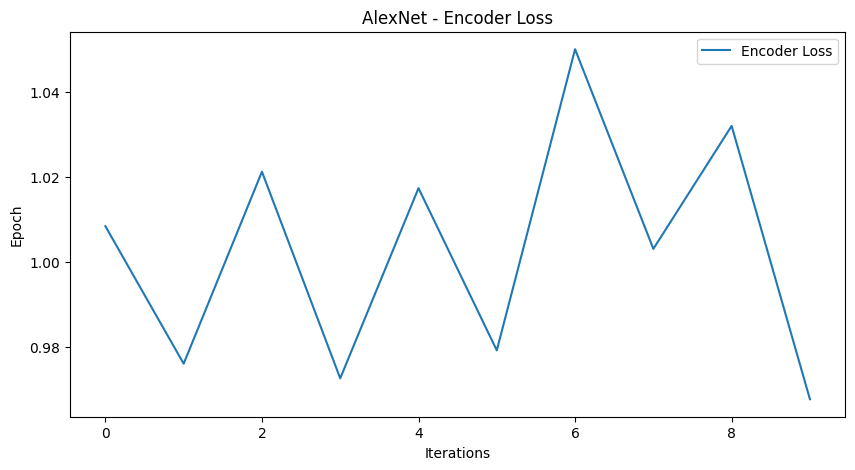

Epoch: 11 | Loss: 0.9517292976379395
Epoch: 12 | Loss: 0.9368188977241516
Epoch: 13 | Loss: 0.9682453870773315
Epoch: 14 | Loss: 0.9511327743530273
Epoch: 15 | Loss: 0.9347531795501709
Epoch: 16 | Loss: 0.9502602815628052
Epoch: 17 | Loss: 0.9328029155731201
Epoch: 18 | Loss: 0.9226282238960266
Epoch: 19 | Loss: 0.972802996635437
Epoch: 20 | Loss: 0.91311115026474


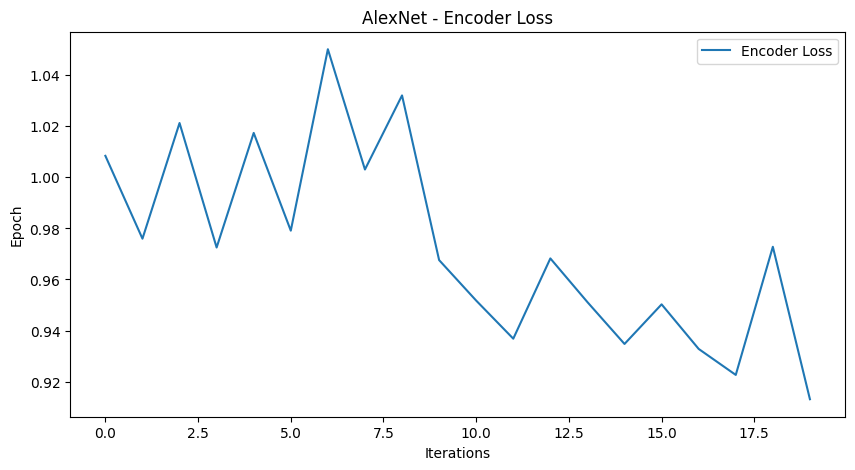

Epoch: 21 | Loss: 0.917015790939331
Epoch: 22 | Loss: 0.9178362488746643
Epoch: 23 | Loss: 0.9067983627319336
Epoch: 24 | Loss: 0.8860106468200684
Epoch: 25 | Loss: 0.8872499465942383
Epoch: 26 | Loss: 0.8731832504272461
Epoch: 27 | Loss: 0.8534133434295654
Epoch: 28 | Loss: 0.8570639491081238
Epoch: 29 | Loss: 0.8470608592033386
Epoch: 30 | Loss: 0.8586497902870178


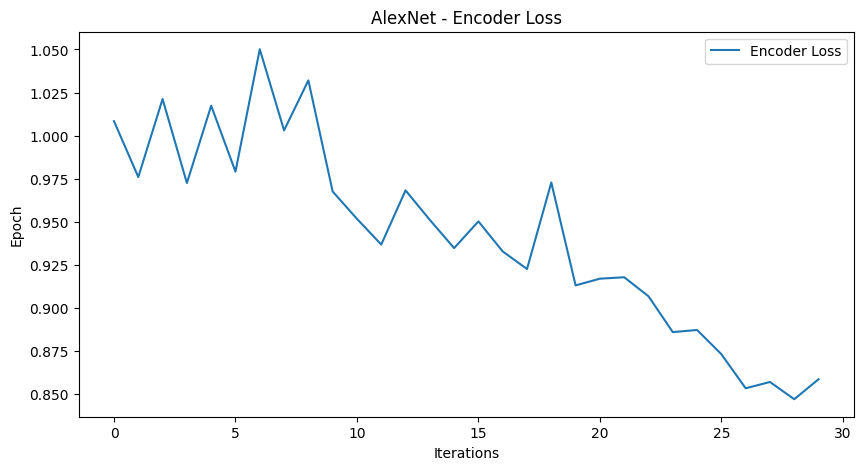

Epoch: 31 | Loss: 0.8658215999603271
Epoch: 32 | Loss: 0.8407778143882751
Epoch: 33 | Loss: 0.7981474995613098
Epoch: 34 | Loss: 0.8110598921775818
Epoch: 35 | Loss: 0.8023040294647217
Epoch: 36 | Loss: 0.7806476950645447
Epoch: 37 | Loss: 0.7686202526092529
Epoch: 38 | Loss: 0.7557220458984375
Epoch: 39 | Loss: 0.7678795456886292
Epoch: 40 | Loss: 0.7301985621452332


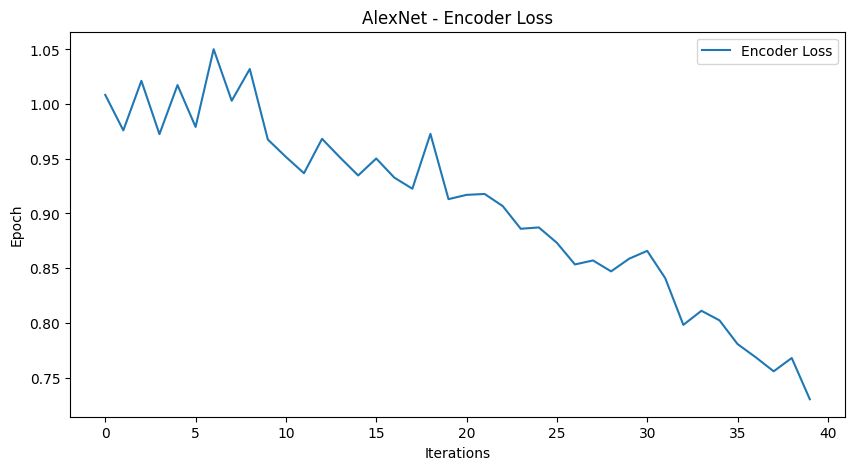

Epoch: 41 | Loss: 0.7305263876914978
Epoch: 42 | Loss: 0.7055405378341675
Epoch: 43 | Loss: 0.7201557159423828
Epoch: 44 | Loss: 0.7147271037101746
Epoch: 45 | Loss: 0.7184044122695923
Epoch: 46 | Loss: 0.6754462718963623
Epoch: 47 | Loss: 0.6927393674850464
Epoch: 48 | Loss: 0.6698111295700073
Epoch: 49 | Loss: 0.6419892311096191
Epoch: 50 | Loss: 0.64926677942276


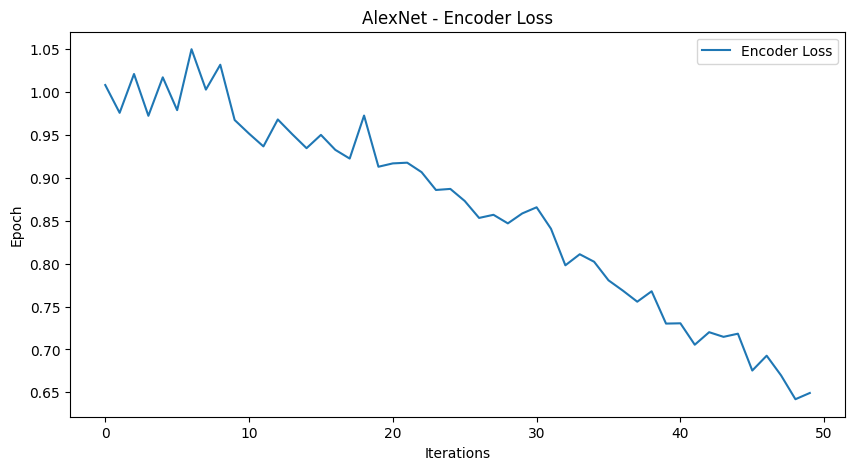

Epoch: 51 | Loss: 0.6529403328895569
Epoch: 52 | Loss: 0.6428747177124023
Epoch: 53 | Loss: 0.6351931095123291
Epoch: 54 | Loss: 0.6277669668197632
Epoch: 55 | Loss: 0.6327657699584961
Epoch: 56 | Loss: 0.6236308217048645
Epoch: 57 | Loss: 0.6139358878135681
Epoch: 58 | Loss: 0.5909897685050964
Epoch: 59 | Loss: 0.5910407304763794
Epoch: 60 | Loss: 0.5673064589500427


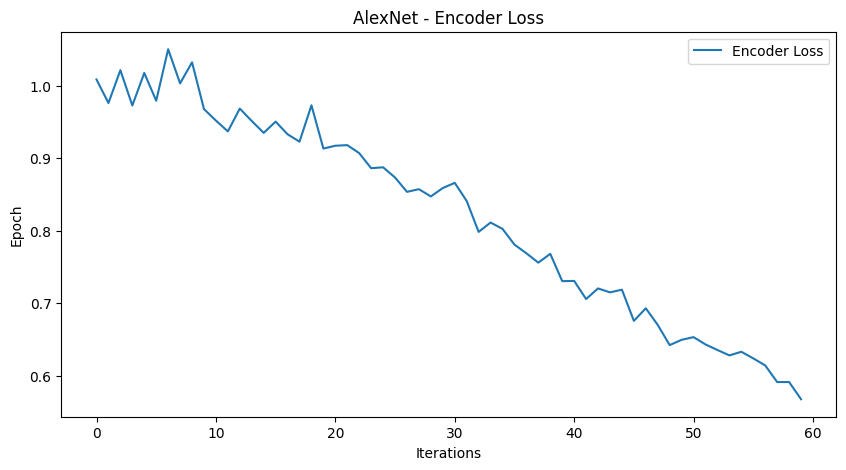

Epoch: 61 | Loss: 0.5537791848182678
Epoch: 62 | Loss: 0.5774596929550171
Epoch: 63 | Loss: 0.5475419163703918
Epoch: 64 | Loss: 0.558893620967865
Epoch: 65 | Loss: 0.5439366102218628
Epoch: 66 | Loss: 0.5315585136413574
Epoch: 67 | Loss: 0.5259877443313599
Epoch: 68 | Loss: 0.5305101275444031
Epoch: 69 | Loss: 0.5083602070808411
Epoch: 70 | Loss: 0.5070395469665527


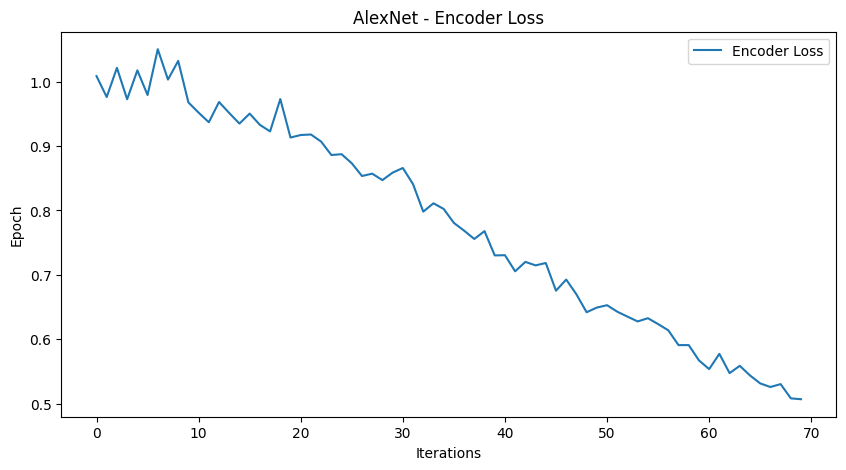

Epoch: 71 | Loss: 0.5249460339546204
Epoch: 72 | Loss: 0.5036894083023071
Epoch: 73 | Loss: 0.49833887815475464
Epoch: 74 | Loss: 0.49714550375938416
Epoch: 75 | Loss: 0.47725293040275574
Epoch: 76 | Loss: 0.505794882774353
Epoch: 77 | Loss: 0.4795266389846802
Epoch: 78 | Loss: 0.4699483811855316
Epoch: 79 | Loss: 0.4531024992465973
Epoch: 80 | Loss: 0.4755646586418152


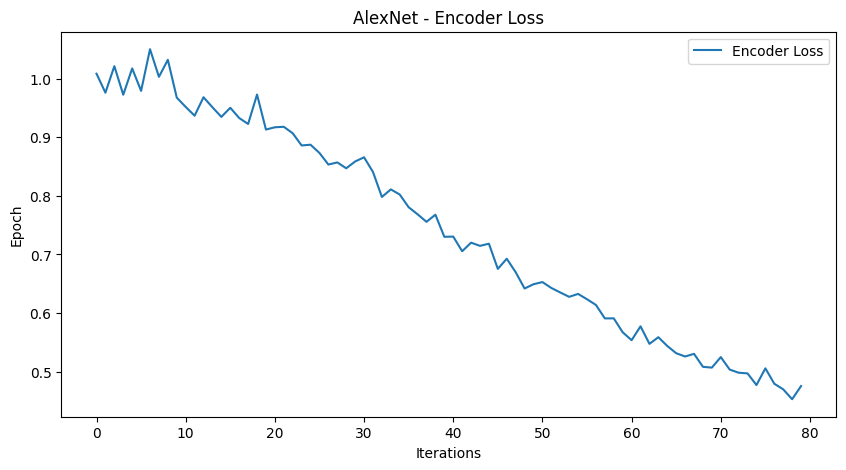

Epoch: 81 | Loss: 0.45261090993881226
Epoch: 82 | Loss: 0.4456261992454529
Epoch: 83 | Loss: 0.42943403124809265
Epoch: 84 | Loss: 0.4427527189254761
Epoch: 85 | Loss: 0.4405747354030609
Epoch: 86 | Loss: 0.4022248387336731
Epoch: 87 | Loss: 0.44028767943382263
Epoch: 88 | Loss: 0.4169626533985138
Epoch: 89 | Loss: 0.39780887961387634
Epoch: 90 | Loss: 0.4035339653491974


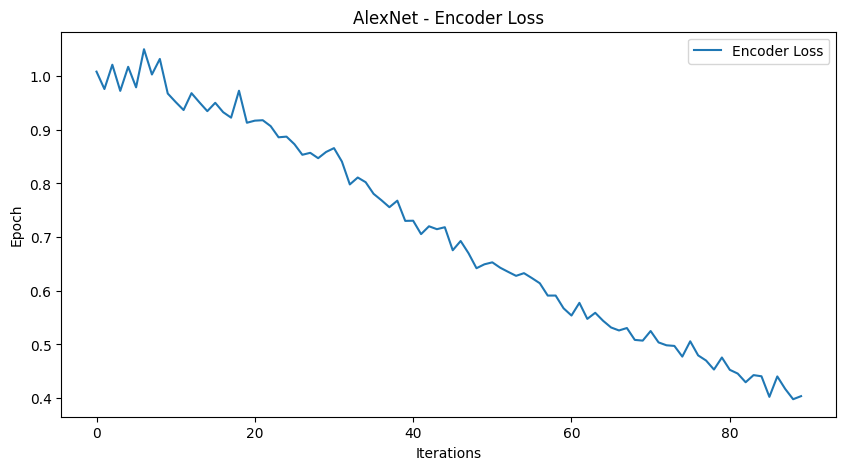

Epoch: 91 | Loss: 0.4345652461051941
Epoch: 92 | Loss: 0.4110144376754761
Epoch: 93 | Loss: 0.3867906630039215
Epoch: 94 | Loss: 0.41826316714286804
Epoch: 95 | Loss: 0.3888004720211029
Epoch: 96 | Loss: 0.3708890378475189
Epoch: 97 | Loss: 0.40256407856941223
Epoch: 98 | Loss: 0.3883962333202362
Epoch: 99 | Loss: 0.3764674961566925
Epoch: 100 | Loss: 0.38552993535995483


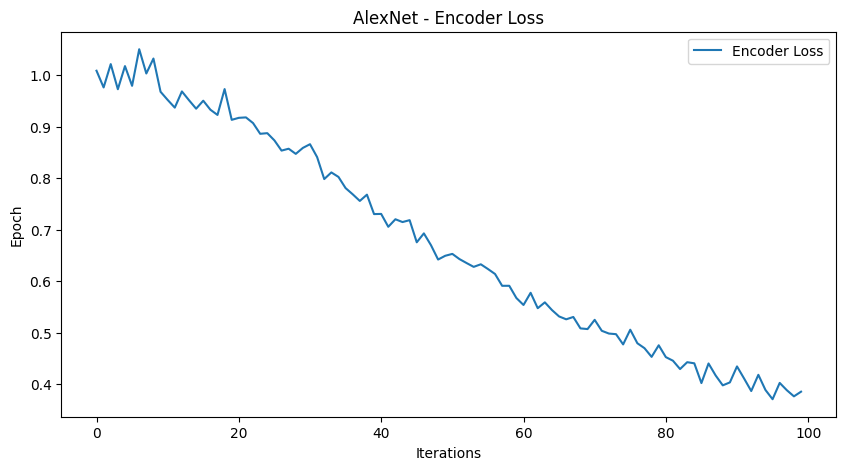

Epoch: 101 | Loss: 0.3685775101184845
Epoch: 102 | Loss: 0.3844815194606781
Epoch: 103 | Loss: 0.3526591360569
Epoch: 104 | Loss: 0.3578241467475891
Epoch: 105 | Loss: 0.35506680607795715
Epoch: 106 | Loss: 0.34616461396217346
Epoch: 107 | Loss: 0.3414621651172638
Epoch: 108 | Loss: 0.3309828042984009
Epoch: 109 | Loss: 0.3487134575843811
Epoch: 110 | Loss: 0.36314865946769714


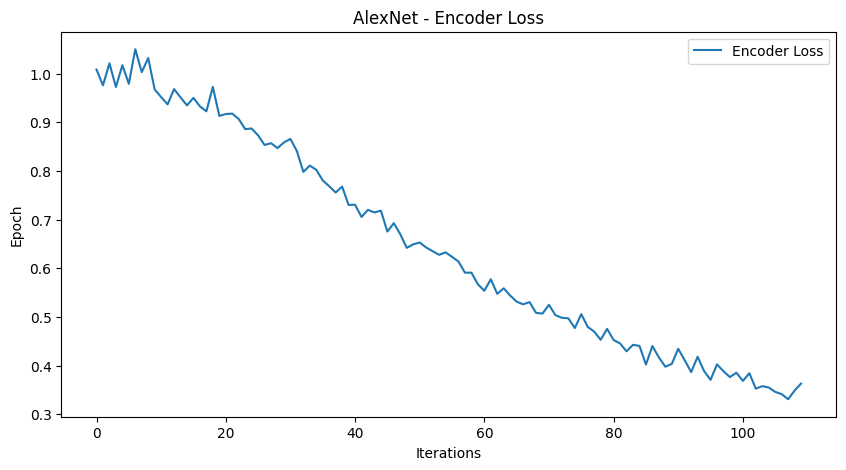

Epoch: 111 | Loss: 0.36491212248802185
Epoch: 112 | Loss: 0.3463155925273895
Epoch: 113 | Loss: 0.31161436438560486
Epoch: 114 | Loss: 0.33206239342689514
Epoch: 115 | Loss: 0.33864274621009827
Epoch: 116 | Loss: 0.3232078552246094
Epoch: 117 | Loss: 0.3082221746444702
Epoch: 118 | Loss: 0.30044490098953247
Epoch: 119 | Loss: 0.3259515166282654
Epoch: 120 | Loss: 0.3159395754337311


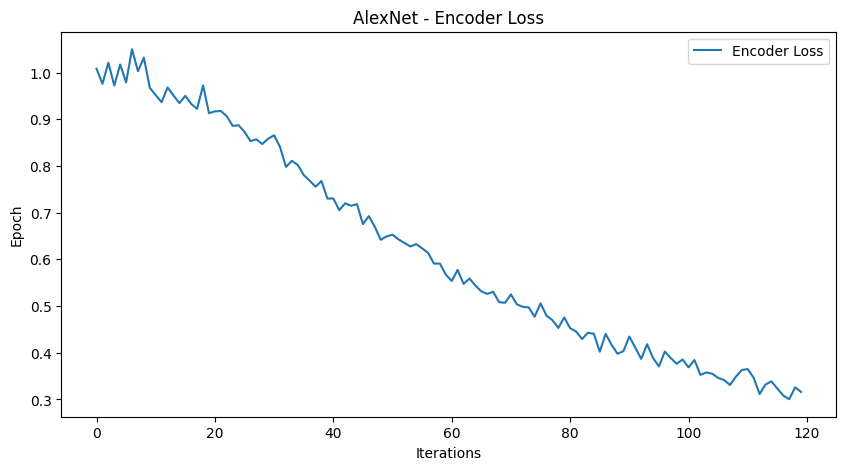

Epoch: 121 | Loss: 0.3038618862628937
Epoch: 122 | Loss: 0.30962660908699036
Epoch: 123 | Loss: 0.3077429533004761
Epoch: 124 | Loss: 0.2964424192905426
Epoch: 125 | Loss: 0.30242210626602173
Epoch: 126 | Loss: 0.29185372591018677
Epoch: 127 | Loss: 0.27971982955932617
Epoch: 128 | Loss: 0.29356351494789124
Epoch: 129 | Loss: 0.2774641215801239
Epoch: 130 | Loss: 0.2628372311592102


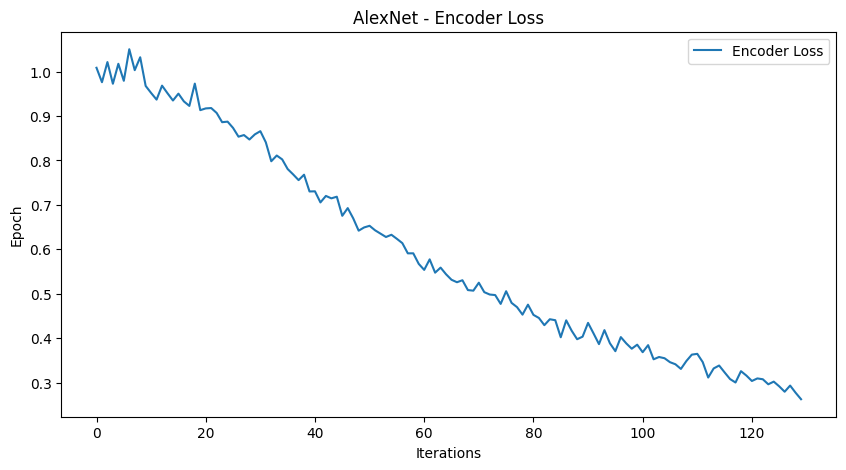

Epoch: 131 | Loss: 0.26053062081336975
Epoch: 132 | Loss: 0.2892502546310425
Epoch: 133 | Loss: 0.2878955900669098
Epoch: 134 | Loss: 0.28725260496139526
Epoch: 135 | Loss: 0.29362645745277405
Epoch: 136 | Loss: 0.27148377895355225
Epoch: 137 | Loss: 0.26553666591644287
Epoch: 138 | Loss: 0.2829468846321106
Epoch: 139 | Loss: 0.2651953101158142
Epoch: 140 | Loss: 0.26957041025161743


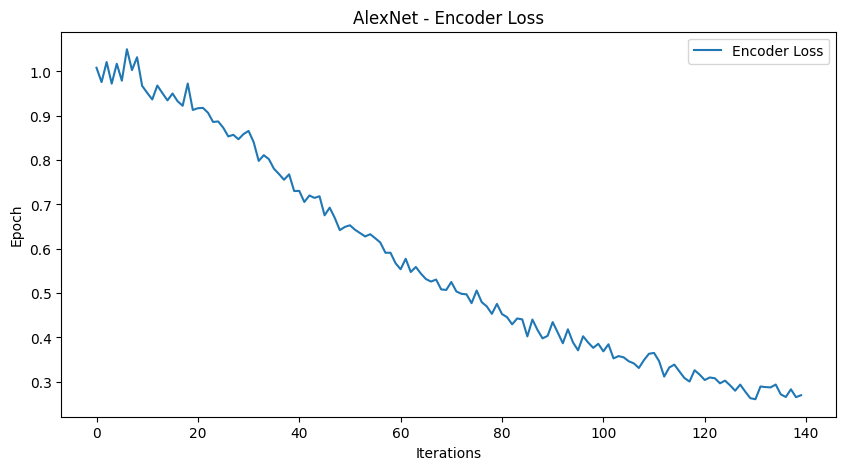

Epoch: 141 | Loss: 0.29051673412323
Epoch: 142 | Loss: 0.2525652348995209
Epoch: 143 | Loss: 0.2840329706668854
Epoch: 144 | Loss: 0.2719346582889557
Epoch: 145 | Loss: 0.25471845269203186
Epoch: 146 | Loss: 0.2505989074707031
Epoch: 147 | Loss: 0.26240280270576477
Epoch: 148 | Loss: 0.24577851593494415
Epoch: 149 | Loss: 0.2509932518005371
Epoch: 150 | Loss: 0.257203608751297


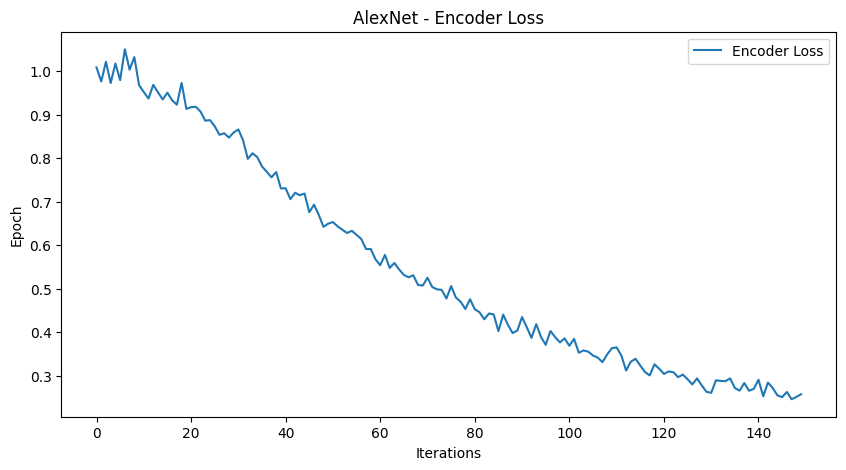

Epoch: 151 | Loss: 0.264963299036026
Epoch: 152 | Loss: 0.24659223854541779
Epoch: 153 | Loss: 0.2521440088748932
Epoch: 154 | Loss: 0.257271945476532
Epoch: 155 | Loss: 0.2379913479089737
Epoch: 156 | Loss: 0.2642400562763214
Epoch: 157 | Loss: 0.23601338267326355
Epoch: 158 | Loss: 0.24887877702713013
Epoch: 159 | Loss: 0.21888643503189087
Epoch: 160 | Loss: 0.2528532147407532


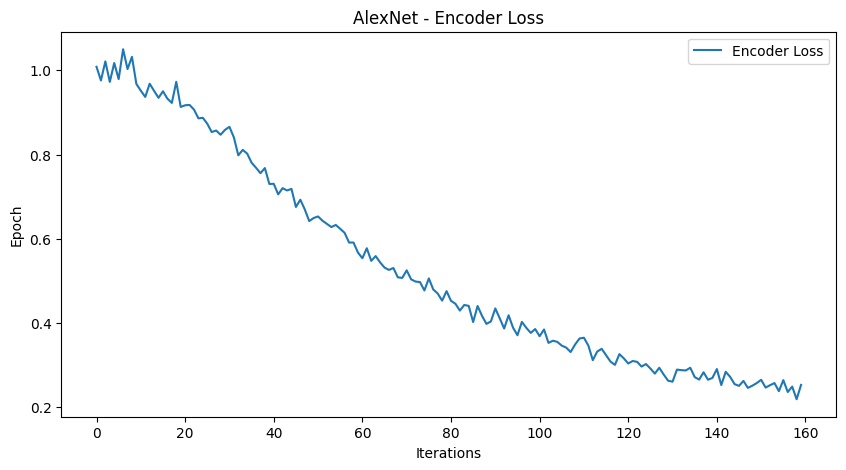

Epoch: 161 | Loss: 0.21069210767745972
Epoch: 162 | Loss: 0.21953076124191284
Epoch: 163 | Loss: 0.23432490229606628
Epoch: 164 | Loss: 0.2193211019039154
Epoch: 165 | Loss: 0.21365401148796082
Epoch: 166 | Loss: 0.21720433235168457
Epoch: 167 | Loss: 0.24237017333507538
Epoch: 168 | Loss: 0.21761353313922882
Epoch: 169 | Loss: 0.22160278260707855
Epoch: 170 | Loss: 0.21293970942497253


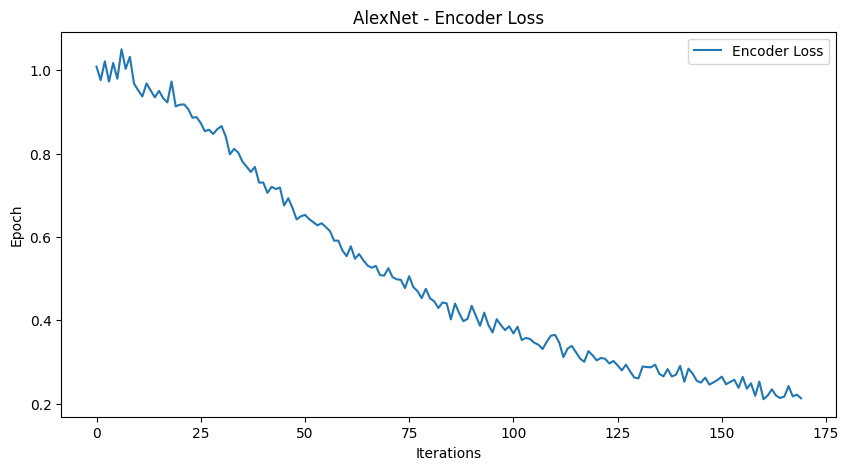

Epoch: 171 | Loss: 0.21357713639736176
Epoch: 172 | Loss: 0.22166407108306885
Epoch: 173 | Loss: 0.19927339255809784
Epoch: 174 | Loss: 0.22349216043949127
Epoch: 175 | Loss: 0.22283659875392914
Epoch: 176 | Loss: 0.19907039403915405
Epoch: 177 | Loss: 0.21004998683929443
Epoch: 178 | Loss: 0.20645293593406677
Epoch: 179 | Loss: 0.2074485868215561
Epoch: 180 | Loss: 0.2075512558221817


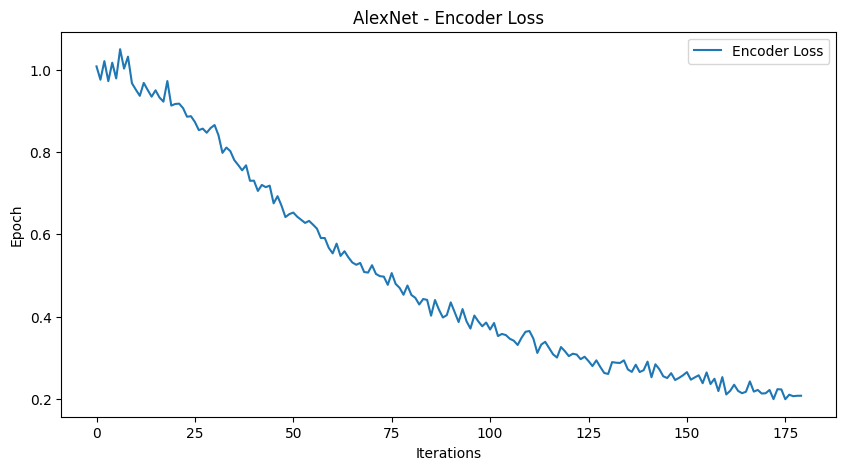

Epoch: 181 | Loss: 0.2147318422794342
Epoch: 182 | Loss: 0.21607545018196106
Epoch: 183 | Loss: 0.20257523655891418
Epoch: 184 | Loss: 0.20127436518669128
Epoch: 185 | Loss: 0.19485320150852203
Epoch: 186 | Loss: 0.20430928468704224
Epoch: 187 | Loss: 0.20180146396160126
Epoch: 188 | Loss: 0.220106303691864
Epoch: 189 | Loss: 0.18929491937160492
Epoch: 190 | Loss: 0.20060043036937714


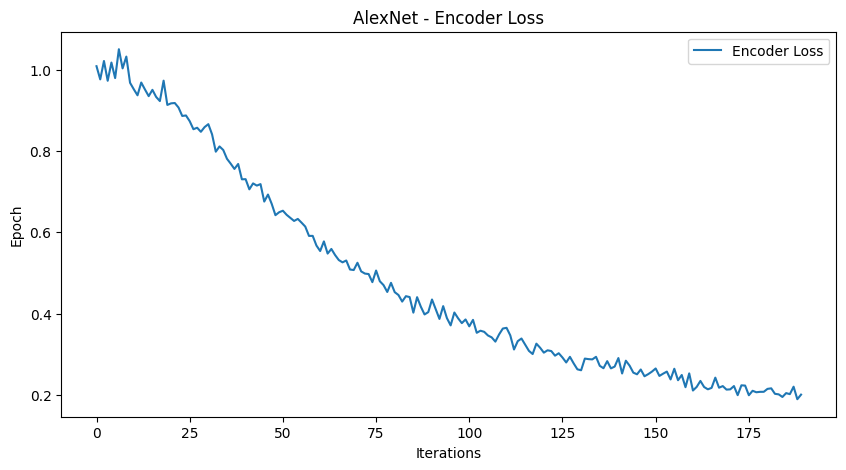

Epoch: 191 | Loss: 0.19706936180591583
Epoch: 192 | Loss: 0.1975160539150238
Epoch: 193 | Loss: 0.1884155422449112
Epoch: 194 | Loss: 0.18268835544586182
Epoch: 195 | Loss: 0.1946355551481247
Epoch: 196 | Loss: 0.20715099573135376
Epoch: 197 | Loss: 0.20143069326877594
Epoch: 198 | Loss: 0.20363254845142365
Epoch: 199 | Loss: 0.18831388652324677
Epoch: 200 | Loss: 0.18100552260875702


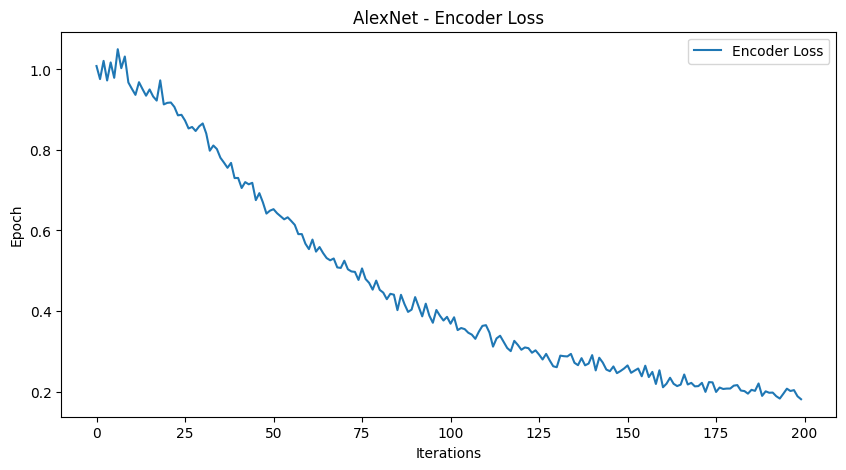

Epoch: 201 | Loss: 0.18404117226600647
Epoch: 202 | Loss: 0.16222378611564636
Epoch: 203 | Loss: 0.19093582034111023
Epoch: 204 | Loss: 0.20066294074058533
Epoch: 205 | Loss: 0.17149043083190918
Epoch: 206 | Loss: 0.16714319586753845
Epoch: 207 | Loss: 0.17756837606430054
Epoch: 208 | Loss: 0.1896047741174698
Epoch: 209 | Loss: 0.18903639912605286
Epoch: 210 | Loss: 0.18138450384140015


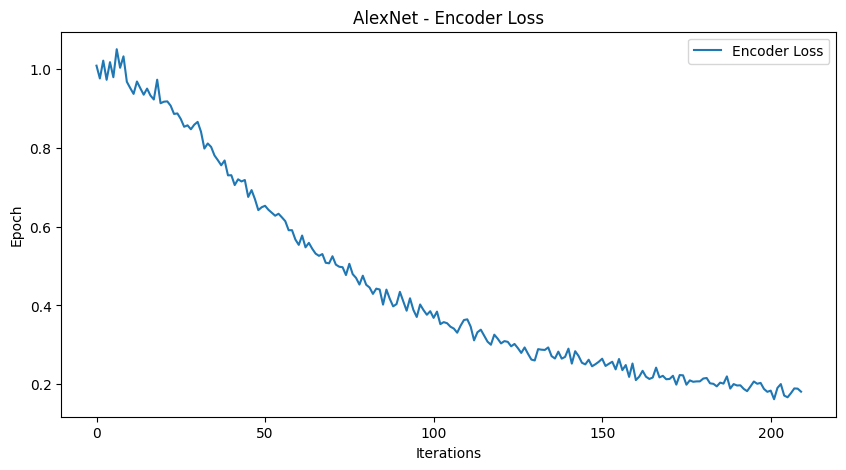

Epoch: 211 | Loss: 0.17106091976165771
Epoch: 212 | Loss: 0.1827569603919983
Epoch: 213 | Loss: 0.15252181887626648
Epoch: 214 | Loss: 0.1804572343826294
Epoch: 215 | Loss: 0.16372737288475037
Epoch: 216 | Loss: 0.17193114757537842
Epoch: 217 | Loss: 0.1787237823009491
Epoch: 218 | Loss: 0.18385663628578186
Epoch: 219 | Loss: 0.16294601559638977
Epoch: 220 | Loss: 0.1489211618900299


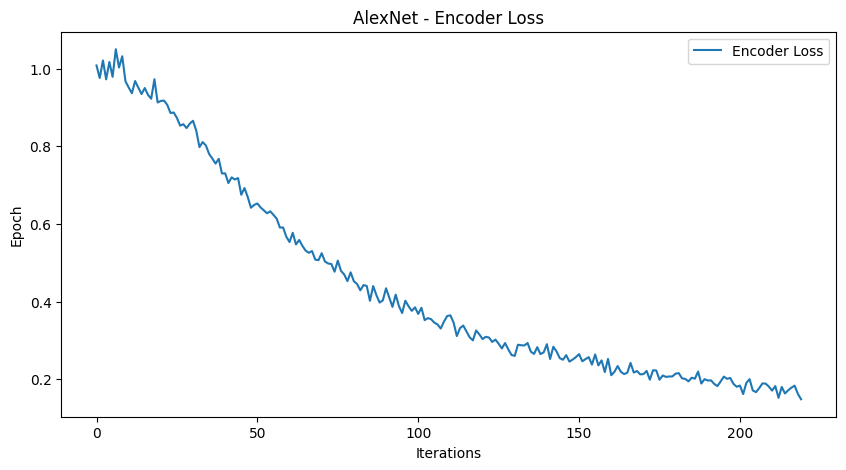

Epoch: 221 | Loss: 0.19202986359596252
Epoch: 222 | Loss: 0.16081012785434723
Epoch: 223 | Loss: 0.19575753808021545
Epoch: 224 | Loss: 0.14950738847255707
Epoch: 225 | Loss: 0.18177521228790283
Epoch: 226 | Loss: 0.16457118093967438
Epoch: 227 | Loss: 0.17133988440036774
Epoch: 228 | Loss: 0.15688370168209076
Epoch: 229 | Loss: 0.14880293607711792
Epoch: 230 | Loss: 0.1658223569393158


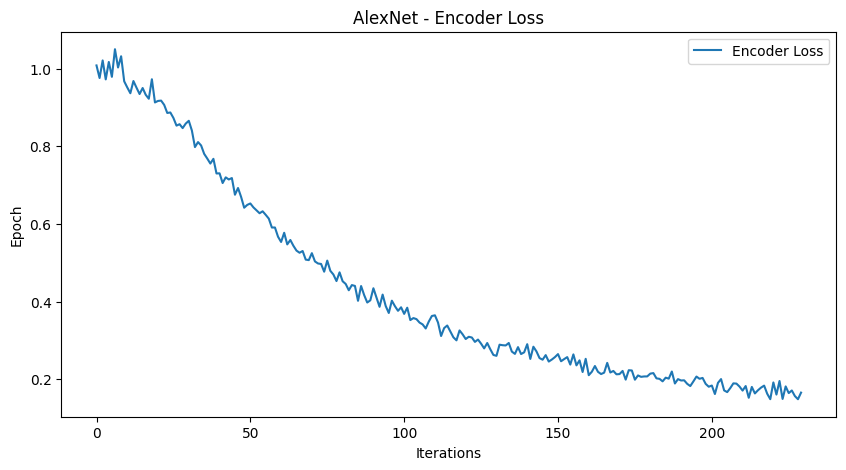

Epoch: 231 | Loss: 0.17053592205047607
Epoch: 232 | Loss: 0.15755042433738708
Epoch: 233 | Loss: 0.17241063714027405
Epoch: 234 | Loss: 0.1598910540342331
Epoch: 235 | Loss: 0.16247588396072388
Epoch: 236 | Loss: 0.15691429376602173
Epoch: 237 | Loss: 0.14779843389987946
Epoch: 238 | Loss: 0.163521409034729
Epoch: 239 | Loss: 0.15053562819957733
Epoch: 240 | Loss: 0.16117575764656067


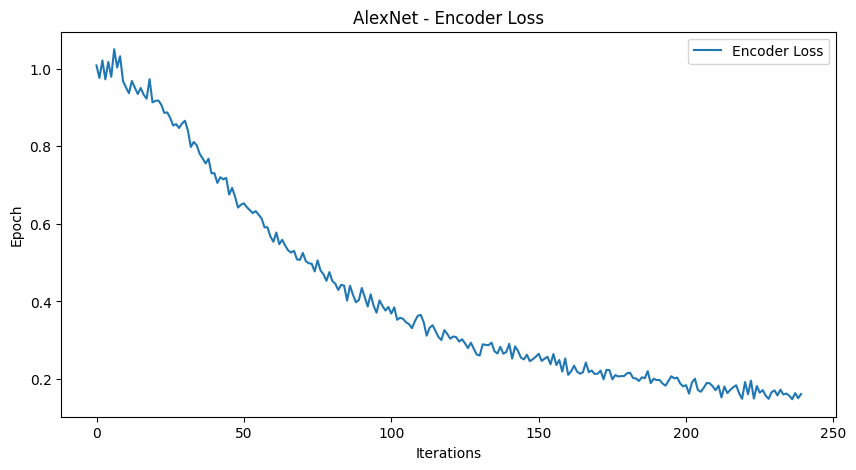

Epoch: 241 | Loss: 0.14368730783462524
Epoch: 242 | Loss: 0.1486622840166092
Epoch: 243 | Loss: 0.1489597111940384
Epoch: 244 | Loss: 0.14243927597999573
Epoch: 245 | Loss: 0.1492149531841278
Epoch: 246 | Loss: 0.158819779753685
Epoch: 247 | Loss: 0.14194463193416595
Epoch: 248 | Loss: 0.15731754899024963
Epoch: 249 | Loss: 0.1795286238193512
Epoch: 250 | Loss: 0.1732657253742218


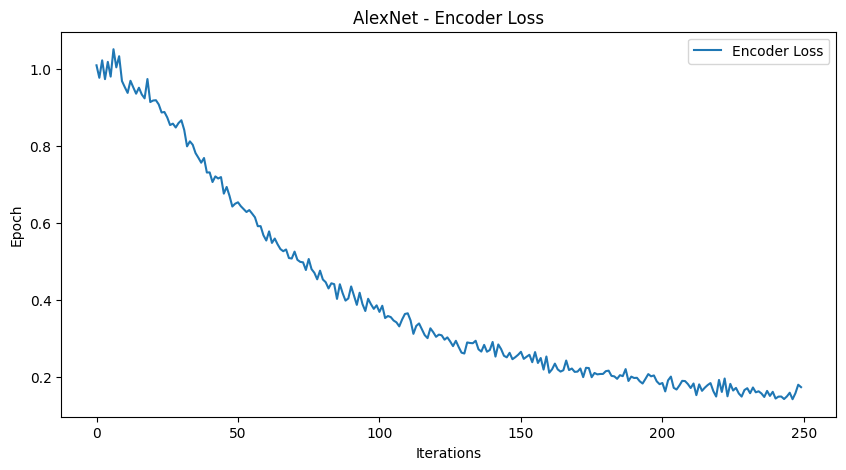

Epoch: 251 | Loss: 0.15649430453777313
Epoch: 252 | Loss: 0.1490224003791809
Epoch: 253 | Loss: 0.15608933568000793
Epoch: 254 | Loss: 0.16643007099628448
Epoch: 255 | Loss: 0.16114728152751923
Epoch: 256 | Loss: 0.1482568085193634
Epoch: 257 | Loss: 0.16073016822338104
Epoch: 258 | Loss: 0.1617281287908554
Epoch: 259 | Loss: 0.1654764711856842
Epoch: 260 | Loss: 0.15950173139572144


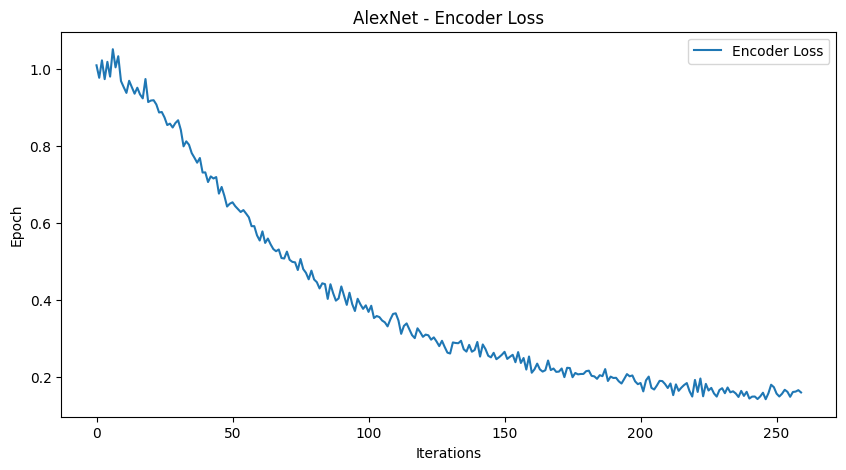

Epoch: 261 | Loss: 0.1647080034017563
Epoch: 262 | Loss: 0.13925249874591827
Epoch: 263 | Loss: 0.14683912694454193
Epoch: 264 | Loss: 0.15405139327049255
Epoch: 265 | Loss: 0.14864683151245117
Epoch: 266 | Loss: 0.1597510725259781
Epoch: 267 | Loss: 0.14434802532196045
Epoch: 268 | Loss: 0.14077214896678925
Epoch: 269 | Loss: 0.14378830790519714
Epoch: 270 | Loss: 0.14508624374866486


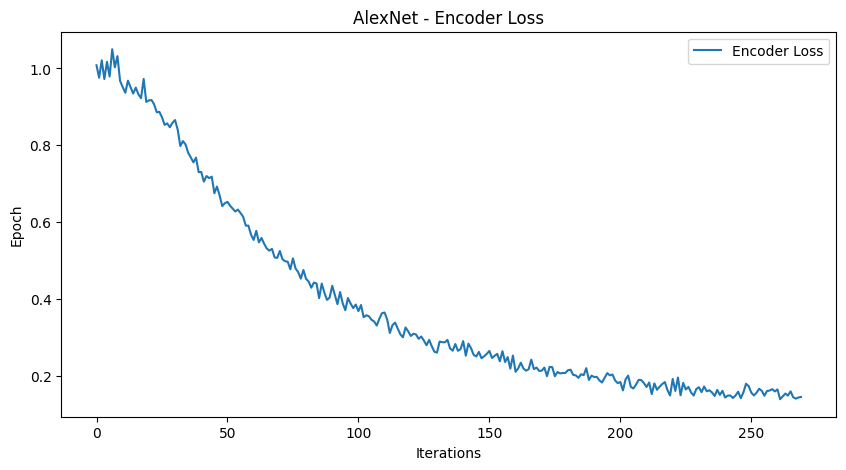

Epoch: 271 | Loss: 0.14731797575950623
Epoch: 272 | Loss: 0.15183988213539124
Epoch: 273 | Loss: 0.13417160511016846
Epoch: 274 | Loss: 0.13920633494853973
Epoch: 275 | Loss: 0.13874542713165283
Epoch: 276 | Loss: 0.15138638019561768
Epoch: 277 | Loss: 0.14696402847766876
Epoch: 278 | Loss: 0.1389821320772171
Epoch: 279 | Loss: 0.13556678593158722
Epoch: 280 | Loss: 0.1510981172323227


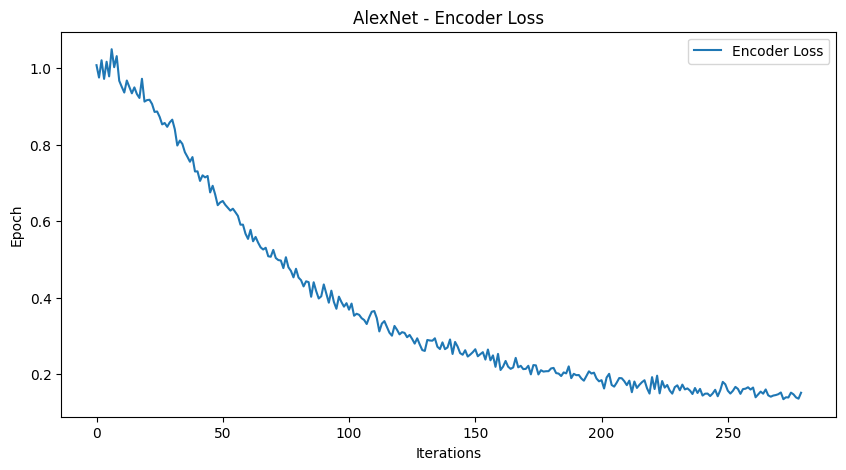

Epoch: 281 | Loss: 0.13452009856700897
Epoch: 282 | Loss: 0.14412160217761993
Epoch: 283 | Loss: 0.1415008306503296
Epoch: 284 | Loss: 0.1409069001674652
Epoch: 285 | Loss: 0.12912176549434662
Epoch: 286 | Loss: 0.12262474000453949
Epoch: 287 | Loss: 0.13777929544448853
Epoch: 288 | Loss: 0.14185881614685059
Epoch: 289 | Loss: 0.13071100413799286
Epoch: 290 | Loss: 0.14984524250030518


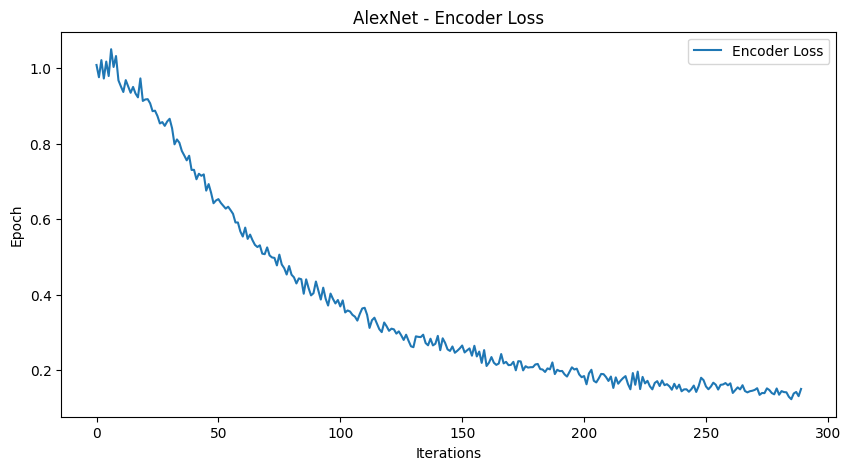

Epoch: 291 | Loss: 0.14181025326251984
Epoch: 292 | Loss: 0.1413033902645111
Epoch: 293 | Loss: 0.1318335086107254
Epoch: 294 | Loss: 0.13879147171974182
Epoch: 295 | Loss: 0.12774480879306793
Epoch: 296 | Loss: 0.13370519876480103
Epoch: 297 | Loss: 0.14889580011367798
Epoch: 298 | Loss: 0.14472736418247223
Epoch: 299 | Loss: 0.1329285055398941
Epoch: 300 | Loss: 0.12704691290855408


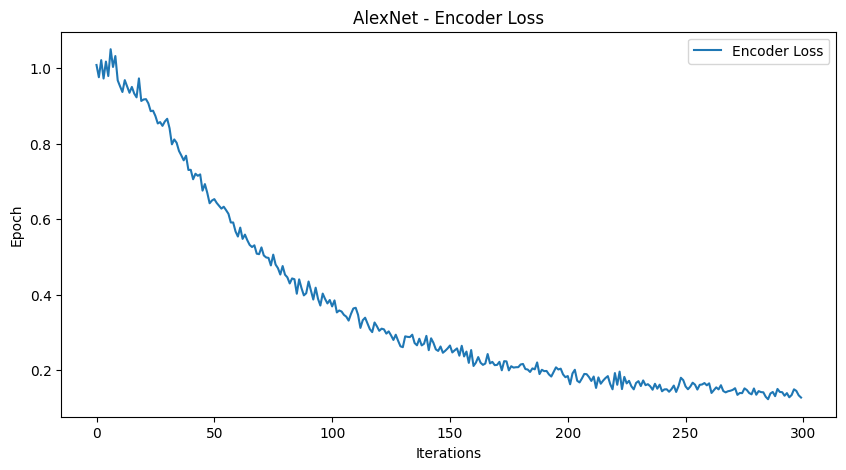

In [20]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs, model_str)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)